In [1]:
from metro_utils import graph, extract_stations, pairs2rails, subsets, total_distance, gen_distance_matrix, graph_x
from station import Station
from city import City
from collections import defaultdict as dd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# Stage 0
TSP

$$\begin{aligned}
&z=\min \sum_{i=1}^{n} \sum_{j=1}^{n} c_{i j} w_{i j} \\
&\text { s.t. } \\
&\sum_{j=1}^{n} w_{i j}=1, \quad i \in I, \\
&\sum_{i=1}^{n} w_{i j}=1, \quad j \in I, \\
&\sum_{i \in S}\sum_{j \in S} w_{ij} \leq |S|-1, \qquad S \subset I, 2 \leq |S| \leq n-1, \\
&w_{i j} \in\{0,1\}, \quad i, j=1, \ldots, n.
\end{aligned}$$

In [2]:
# Load test cases
# Highly recommend https://www.mathsisfun.com/data/cartesian-coordinates-interactive.html for creating these easily

from json import load

ignore_fields = ["description", "comment", "source"]
def filter_ignore(d):
    return {k: v for k, v in d.items() if k not in ignore_fields}

with open("test_cases.json", "r") as f:
    tests = load(f, object_hook=filter_ignore)

In [15]:
# Choose problem to use in code below
test_choice = "barcelona_reference"
locations = tests[test_choice]["locations"]
kinds = tests[test_choice]["kinds"]

city = City(**tests[test_choice])
stations = city.stations

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 262162 rows, 361 columns and 14099976 nonzeros
Model fingerprint: 0x3d9a52d3
Variable types: 0 continuous, 361 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-01, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+00]
Found heuristic solution: objective 14.7930779
Presolve removed 0 rows and 19 columns (presolve time = 5s) ...
Presolve removed 0 rows and 19 columns (presolve time = 11s) ...
Presolve removed 0 rows and 19 columns (presolve time = 15s) ...
Presolve removed 0 rows and 19 columns (presolve time = 21s) ...
Presolve removed 0 rows and 19 columns (presolve time = 25s) ...
Presolve removed 0 rows and 19 columns (presolve time = 30s) ...
Presolve removed 0 rows and 19 columns (presolve time = 37s) ...
Presolve removed 0 rows and 19 columns (presolve time = 

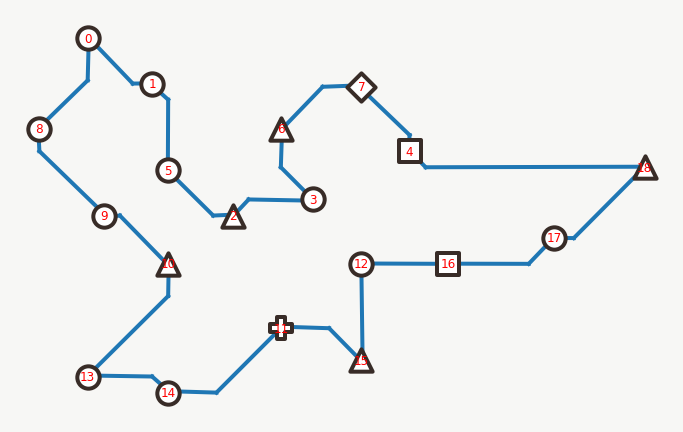

In [26]:
def tsp(city, verbose=True):
    
    n_stations = len(city.stations)
    
    dist = gen_distance_matrix(city)
    
    S = list(range(n_stations))
    subs = subsets(S)
    
    m = gp.Model()
    if not verbose:
        m.setParam('OutputFlag', 0)
    
    w = m.addVars(n_stations, n_stations, vtype=GRB.INTEGER, name="x")

    m.setObjective(gp.quicksum(dist[s1, s2]*w[s1, s2] for s1 in S for s2 in S if s1 != s2), GRB.MINIMIZE)

    # leave each station only once
    m.addConstrs(gp.quicksum(w[s1, s2] for s1 in S if s1 != s2 ) == 1 for s2 in S)
    # enter each station only once
    m.addConstrs(gp.quicksum(w[s1, s2] for s2 in S if s1 != s2 ) == 1 for s1 in S)
    # Subtour elimination constraints
    for sub in subs:
        m.addConstr(gp.quicksum(w[s1, s2] for s1 in sub for s2 in sub if s1 != s2) <= len(sub) - 1)

    m.optimize()
    
    return m
    
m = tsp(city)
best = pairs2rails([extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6])
graph(stations, best, equal_aspect=True)

## Stage 1 - Ants (with Ghost Depot)

In [22]:
import gurobipy as gp
from gurobipy import GRB

def ants(city, verbose=True):
    n_stations = len(city.stations)
    S = list(range(n_stations))
    dist = gen_distance_matrix(city)
    subs = subsets(S)
    
    DUMMY = n_stations
    M = 2
    D = range(M)
    S0 = S + [DUMMY]
    K = 1#3
    L = 100#N_STATIONS - (M-1)*K
    mk = 1 # Num trains from kth depot

    m = gp.Model()
    if not verbose:
        m.setParam('OutputFlag', 0)

    w = m.addVars(n_stations+1, n_stations+1, M, vtype=GRB.BINARY, name="w")
    u = m.addVars(n_stations, vtype=GRB.INTEGER, name="u")

    # 1
    m.setObjective(gp.quicksum(dist[i, j]*w[i, j, k] for k in D for j in S for i in S), GRB.MINIMIZE)

    # 2
    m.addConstrs(gp.quicksum(w[DUMMY, j, k] for j in S) == mk for k in D)
    # 3
    m.addConstrs(gp.quicksum(w[i, j, k] for i in S0 for k in D) == 1 for j in S)
    # 4
    m.addConstrs(gp.quicksum(w[i, j, k] for i in S0) - gp.quicksum(w[j, i, k] for i in S0) == 0
                 for k in D for j in S)
    # 5
    m.addConstrs(gp.quicksum(w[DUMMY, j, k] for j in S) - gp.quicksum(w[j, DUMMY, k] for j in S) == 0 for k in D)
    # 6
    m.addConstrs(u[i] + (L - 2)*gp.quicksum(w[DUMMY, i, k] for k in D) - 
                 gp.quicksum(w[i, DUMMY, k] for k in D) <= L - 1 for i in S)
    # 7
    m.addConstrs(u[i] + gp.quicksum(w[DUMMY, i, k] for k in D) + (2 - K)*gp.quicksum(w[i, DUMMY, k] for k in D) >= 2 for i in S)
    # 8
    m.addConstrs(gp.quicksum(w[DUMMY, i, k] for k in D) + gp.quicksum(w[i, DUMMY, k] for k in D) <= 1 for i in S)
    # 9
    m.addConstrs(u[i] - u[j] + L*gp.quicksum(w[i, j, k] for k in D) + 
                 (L - 2)*gp.quicksum(w[j, i, k] for k in D) <= L - 1 for i in S for j in S if i != j)
    # 10
    m.addConstrs(w[i, i, k] == 0 for i in S for k in D)

    m.optimize()
    return m

m = ants(city, verbose=False)

In [23]:
from ast import literal_eval
SOURCE_IDX = 0
TARGET_IDX = 1
RAIL_IDX = 2
DUMMY = len(city.stations)

# Modified connections definition to disquality report of dummy depot-related edges
connections = [extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'w' and \
                  literal_eval(v.varName[1:])[SOURCE_IDX] != DUMMY and literal_eval(v.varName[1:])[TARGET_IDX] != DUMMY]
display(connections)
#connections = [extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'x' and \
#                  literal_eval(v.varName[1:])[0] < n]

rail_pairs = dd(list)
for connection in connections:
    rail_pairs[connection[RAIL_IDX]].append(connection[:2])
    
rail_pairs

[[<0>, <8>, 0],
 [<1>, <0>, 0],
 [<2>, <10>, 0],
 [<3>, <2>, 0],
 [<4>, <7>, 0],
 [<5>, <1>, 0],
 [<6>, <3>, 0],
 [<7>, <6>, 0],
 [<9>, <5>, 0],
 [<10>, <9>, 0],
 [<11>, <15>, 1],
 [<12>, <16>, 1],
 [<13>, <14>, 1],
 [<14>, <11>, 1],
 [<15>, <12>, 1],
 [<16>, <17>, 1],
 [<17>, <18>, 1]]

defaultdict(list,
            {0: [[<0>, <8>],
              [<1>, <0>],
              [<2>, <10>],
              [<3>, <2>],
              [<4>, <7>],
              [<5>, <1>],
              [<6>, <3>],
              [<7>, <6>],
              [<9>, <5>],
              [<10>, <9>]],
             1: [[<11>, <15>],
              [<12>, <16>],
              [<13>, <14>],
              [<14>, <11>],
              [<15>, <12>],
              [<16>, <17>],
              [<17>, <18>]]})

In [24]:
rails = []

for rail, pairs in rail_pairs.items():
    rails.append(pairs2rails(pairs))
    
rails

[[<4>, <7>, <6>, <3>, <2>, <10>, <9>, <5>, <1>, <0>, <8>],
 [<13>, <14>, <11>, <15>, <12>, <16>, <17>, <18>]]

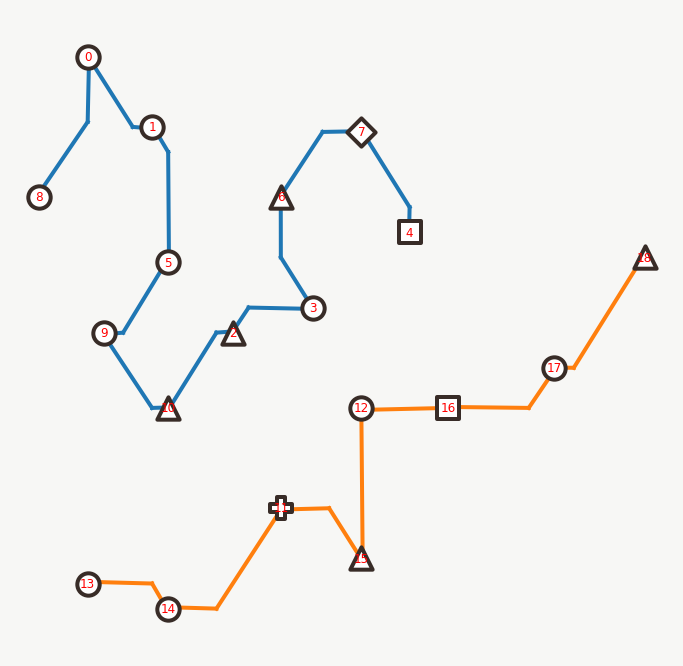

In [25]:
graph(stations, rails)

## Stage 2 - MIP Approach

## SDVRP - Based Implementation

In [16]:
def choose_flow_root(city, debug=False):
    """Returns id of most central station for flow root"""
    positions = np.array(list(map(lambda s: [s.x, s.y], city.stations)))
    mean = positions.sum(0) / len(city.stations)
    if debug: print("Mean: ", mean)
    
    best_s, best_dist = None, 10e5
    for s in city.stations:
        dist = np.linalg.norm(mean - np.array([s.x, s.y]))
        if debug: print((s, s.x, s.y, dist))
        if dist < best_dist:
            best_s, best_dist = s, dist
    
    return best_s.id

In [17]:
def sdvrp(city, verbose=True):
    
    # A few modifications, but otherwise the same hyperparameters
    n = n_stations = len(city.stations)  # no. customers
    M = 4  # no. rails
    D = range(M) # set of vehicles
    S = list(range(n_stations))  # customers
    DUMMY = n  # dummy depot's index
    S0 = S + [DUMMY]  # customers + depot

    d = [1]*n # Customer demands, set to unit
    Q = n  # capacities of vehicles (assumed homogenous)
    K = 1 # min number of visited stations (excluding depot)
    mk = 1 # Num trains from kth depot
    dist = gen_distance_matrix(city)   # cost matrix
    INF = 10e7

    m = gp.Model()
    if not verbose:
        m.setParam('OutputFlag', 0)
        
    K = 1  # relevant to an extra constraint that avoids short-lived train stops; Ants approach would do better here

    w = m.addVars(n_stations+1, n_stations+1, M, vtype=GRB.BINARY, name="w") # node i --> node j on path of vehicle k
    y = m.addVars(n_stations, M, lb=0.0, name="y")  # quantity of ith site's demand satisfied by kth vehicle/route
    u = m.addVars(n_stations, M, lb=0.0, name="u")  # MTZ potentials
    p = m.addVars(n_stations, n_stations, lb=0.0, name="p") # Whole-network flow potentials
    e = m.addVars(n_stations, n_stations, vtype=GRB.BINARY, name="e") # indicators for edge use

    m.setObjective(gp.quicksum(dist[i,j]*w[i,j,k] for i in S for j in S for k in D), GRB.MINIMIZE)
    
    ### FLOW CONSTRAINTS FOR A FC GRAPH
    FLOW_ROOT = choose_flow_root(city)
    # A flow of 1 must exit the 'root'
    m.addConstr(gp.quicksum(p[FLOW_ROOT,j] for j in S if j != FLOW_ROOT) == 1) 
    # cannot have self-flows
    m.addConstrs(p[i,i] <= 0 for i in S)
    # Outflow - Inflow = 1 for non-roots (i.e. all nodes increase flow by one)
    m.addConstrs(gp.quicksum(p[i,j] for j in S) - gp.quicksum(p[j,i] for j in S) == 1 for i in S if i != FLOW_ROOT)
    # Flow can only occur where an edge is formed
    m.addConstrs(p[i,j] <= (n_stations)*e[i,j] for i in S for j in S if i != j)
    # Flow into the root must be N for any edge going into it
    m.addConstrs(gp.quicksum(p[i, FLOW_ROOT] for i in S) == n_stations for i in S if i != FLOW_ROOT)
    # Edge-indicator setup
    m.addConstrs(e[i,j] <= 0.5 + gp.quicksum(w[i,j,k] for k in D) for i in S for j in S)
    m.addConstrs(e[i,j] >= gp.quicksum(w[i,j,k] for k in D) / INF for i in S for j in S)

    ### EDGE CONSISTENCY CONSTRAINTS
    # At least one edge enters every j (including the depot)
    m.addConstrs(gp.quicksum(w[i,j,k] for i in S0 for k in D) >= 1 for j in S0)
    # in == out for every node + depot, per-route basis (and hence in general)
    m.addConstrs((gp.quicksum(w[i,j,k] for i in S0) - gp.quicksum(w[j,i,k] for i in S0) == 0 for j in S0 for k in D))

    ### SUBTOUR CONSTRAINTS 
    # SEC using MTZ
    m.addConstrs((u[i,k] - u[j,k] + n_stations*w[i,j,k] <= n_stations-1 + \
                      n_stations*w[j,DUMMY,k] for i in S for j in S if i != j for k in D))

    ### DEMAND CONSTRANTS
    # ith demand can only be sated by route k if there's an outbound edge from i on that path
    m.addConstrs(y[i,k] <= d[i]*gp.quicksum(w[i,j,k] for j in S0) for i in S for k in D)
    # Total sated demand @ i must meet demand
    m.addConstrs(gp.quicksum(y[i,k] for k in D) == d[i] for i in S)
    # Total sated demand by k cannot exceed capacity of vehicle
    m.addConstrs((gp.quicksum(y[i,k] for i in S) <= Q for k in D))

    ### OTHER constraints
    # No self-joins
    m.addConstrs(w[i,i,k] <= 0 for i in S0 for k in D)
    # For a given k, you must (and only once) enter the dummy depot, and leave the dummy depot
    m.addConstrs(gp.quicksum(w[i,DUMMY,k] for i in S) == mk for k in D)
    m.addConstrs(gp.quicksum(w[DUMMY,i,k] for i in S) == mk for k in D)
    # Same vehicle cannot cross the same connection twice (excluding depot)
    m.addConstrs((w[i,j,k] + w[j,i,k] <= 1 for i in S for j in S for k in D))
    # Routes must have more than K edges (K >= 1)
    m.addConstrs((gp.quicksum(w[i,j,k] for i in S for j in S) >= K for k in D))

    m.optimize()
    
    return m
    
m = sdvrp(city)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4223 rows, 2474 columns and 21669 nonzeros
Model fingerprint: 0xee5aefc1
Variable types: 513 continuous, 1961 integer (1961 binary)
Coefficient statistics:
  Matrix range     [1e-08, 2e+01]
  Objective range  [3e-01, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 2e+01]
Presolve removed 1265 rows and 118 columns
Presolve time: 0.06s
Presolved: 2958 rows, 2356 columns, 17366 nonzeros
Variable types: 494 continuous, 1862 integer (1862 binary)

Root relaxation: objective 4.045281e+00, 1448 iterations, 0.11 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    4.04528    0   86          -    4.04528      -     -    0s
     0     0    4.45225    0  100          -    4.45225      -  

In [18]:
for var in m.getVars():
    if abs(var.x) > 0:# or var.varName[0] in "p":
        print(var.varName, var.x)

w[0,1,0] 1.0
w[1,5,0] 1.0
w[2,3,0] 1.0
w[3,6,3] 1.0
w[3,19,0] 1.0
w[3,19,1] 1.0
w[4,7,1] 1.0
w[5,9,0] 1.0
w[6,3,1] 1.0
w[6,19,3] 1.0
w[7,6,1] 1.0
w[8,0,0] 1.0
w[9,10,0] 1.0
w[10,2,0] 1.0
w[11,15,2] 1.0
w[12,3,3] 1.0
w[12,19,2] 1.0
w[13,14,2] 1.0
w[14,11,2] 1.0
w[15,12,2] 1.0
w[16,12,3] 1.0
w[17,16,3] 1.0
w[18,17,3] 1.0
w[19,4,1] 1.0
w[19,8,0] 1.0
w[19,13,2] 1.0
w[19,18,3] 1.0
y[0,0] 1.0
y[1,0] 1.0
y[2,0] 1.0
y[3,1] 1.0
y[4,1] 1.0
y[5,0] 1.0
y[6,1] 1.0
y[7,1] 1.0
y[8,0] 1.0
y[9,0] 1.0
y[10,0] 1.0
y[11,2] 1.0
y[12,3] 1.0
y[13,2] 1.0
y[14,2] 1.0
y[15,2] 1.0
y[16,3] 1.0
y[17,3] 1.0
y[18,3] 1.0
u[0,0] 0.9999999999999432
u[1,0] 1.9999999999997726
u[2,0] 5.999999999998977
u[3,3] 3.9999999999987956
u[5,0] 2.9999999999999147
u[6,1] 1.9999999999998863
u[7,1] 0.9999999999999432
u[9,0] 3.9999999999998295
u[10,0] 4.999999999999744
u[11,2] 1.9999999999999432
u[12,3] 2.9999999999996696
u[14,2] 0.9999999999999716
u[15,2] 2.9999999999998863
u[16,3] 1.9999999999999005
u[17,3] 0.9999999999999787
p[0,1] 1

In [19]:
from ast import literal_eval
SOURCE_IDX = 0
TARGET_IDX = 1
RAIL_IDX = 2
DUMMY = len(city.stations)

connections = [extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'w' and \
                  literal_eval(v.varName[1:])[SOURCE_IDX] != DUMMY and literal_eval(v.varName[1:])[TARGET_IDX] != DUMMY]
display(connections)

rail_pairs = dd(list)
for connection in connections:
    rail_pairs[connection[RAIL_IDX]].append(connection[:2])
    
rail_pairs

[[<0>, <1>, 0],
 [<1>, <5>, 0],
 [<2>, <3>, 0],
 [<3>, <6>, 3],
 [<4>, <7>, 1],
 [<5>, <9>, 0],
 [<6>, <3>, 1],
 [<7>, <6>, 1],
 [<8>, <0>, 0],
 [<9>, <10>, 0],
 [<10>, <2>, 0],
 [<11>, <15>, 2],
 [<12>, <3>, 3],
 [<13>, <14>, 2],
 [<14>, <11>, 2],
 [<15>, <12>, 2],
 [<16>, <12>, 3],
 [<17>, <16>, 3],
 [<18>, <17>, 3]]

defaultdict(list,
            {0: [[<0>, <1>],
              [<1>, <5>],
              [<2>, <3>],
              [<5>, <9>],
              [<8>, <0>],
              [<9>, <10>],
              [<10>, <2>]],
             3: [[<3>, <6>],
              [<12>, <3>],
              [<16>, <12>],
              [<17>, <16>],
              [<18>, <17>]],
             1: [[<4>, <7>], [<6>, <3>], [<7>, <6>]],
             2: [[<11>, <15>], [<13>, <14>], [<14>, <11>], [<15>, <12>]]})

In [20]:
rails = []

for rail, pairs in rail_pairs.items():
    rails.append(pairs2rails(pairs, debug=False))

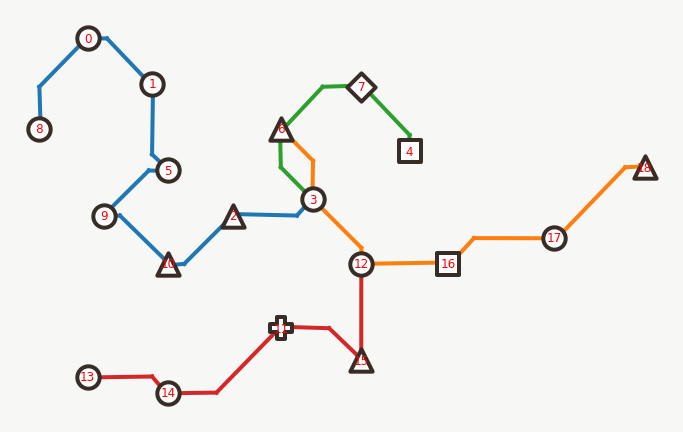

In [21]:
graph(stations, rails, jitter=True, equal_aspect=True)

### Random

- `hexagon` + biased demand weights == easy check that overlap is okay
- `loop_feasibility` + negative costs == easy check that loops are okay 
- `donut` == easy check for a problem that needs a loop solution

# Metaheuristics

In [ ]:
from numpy.random import shuffle, randint, choice
from copy import deepcopy

def initialise(N, K):
    x = np.zeros((N, N, K))
    
    order = list(range(N))
    
    for k in range(K):
        shuffle(order)
        for i in range(N-1):
            a = order[i]
            b = order[i+1]
            x[a, b, k] = x[b, a, k] = 1
            
    return x      

isolated_station = lambda x: not all(x.sum(axis=2).sum(axis=0))
rail_covers_every_station = lambda grid: not any(grid.sum(axis=0) == 0)
has_loop = lambda grid: not any(grid.sum(axis=0) == 1)
just_two_stations = lambda grid: (grid.sum() == 2)
get_stations_not_on_line = lambda grid: (grid.sum(axis=0) == 0).nonzero()[0]
get_middle_stations = lambda grid: (grid.sum(axis=0) == 2).nonzero()[0]
get_end_stations    = lambda grid: (grid.sum(axis=0) == 1).nonzero()[0]
get_line_stations   = lambda grid: (grid.sum(axis=0) != 0).nonzero()[0]
has_subtours = lambda grid: len(get_end_stations(grid)) > 2

def get_neighbour(x, case=0):
    x = deepcopy(x)
    # How many lines to modify
    m = 1 + randint(x.shape[2])
    
    lines = list(range(x.shape[2]))
    shuffle(lines)
    
    lines_to_modify = lines[:m]
    
    for k in lines_to_modify:
        grid = x[:, :, k]
        
        case = choice([1, 2, 3, 4]) if case == 0 else case
        
        if case == 1:
            # Case 1. Expand Rail line end (Includes forming loop)
            if not has_loop(grid):
                old_choices = list(get_end_stations(grid))
                new_choices = list(get_stations_not_on_line(grid)) + old_choices
                
                old = choice(old_choices)
                new = choice(new_choices)
                
                if new != old:
                    grid[old, new] = grid[new, old] = 1

        elif case == 2:
            # Case 2. Shrink Rail line end (Includes breaking loop)
            # This can make city invalid (considering station kinds)
            # But cost function makes the cost really high
            if has_loop(grid):
                # Pick edge to break
                choices = np.array(grid.nonzero()).T
                i, j = choices[choice(range(len(choices)))]
                grid[i, j] = grid[j, i] = 0
            else:
                # Pick end to shrink
                ends = get_end_stations(grid)
                old_end = choice(ends)
                new_end = grid[old_end, :].argmax()
                grid[old_end, new_end] = grid[new_end, old_end] = 0

                if isolated_station(x):
                    grid[old_end, new_end] = grid[new_end, old_end] = 1

        elif case == 3:
            # Case 3. Add station in middle
            if not rail_covers_every_station(grid):
                choices = get_stations_not_on_line(grid)
                b = choice(choices)
                
                a = choice(get_line_stations(grid))
                c = grid[a].nonzero()[0]
                
                grid[a, b] = grid[b, a] = grid[b, c] = grid[c, b] = 1
                grid[a, c] = grid[c, a] = 0

        elif case == 4:
            # Case 4. Remove station in middle
            # If not just 2 stations
            if not just_two_stations(grid):
                choices = get_middle_stations(grid)
                b = choice(choices)
                a, c = grid[b, :].nonzero()[0]
                grid[a, b] = grid[b, a] = grid[b, c] = grid[c, b] = 0
                prev_ac = grid[a, c]
                grid[a, c] = grid[c, a] = 1

                if isolated_station(x):
                    grid[a, b] = grid[b, a] = grid[b, c] = grid[c, b] = 1
                    grid[a, c] = grid[c, a] = prev_ac
        
    return x


import networkx as nx
from networkx import from_numpy_matrix

M = 1e5

def cost(stations, x):
    connections = 1 * (x.sum(axis=2) > 0)
    dist = gen_distance_matrix(city).round(2)
    # weighted_adjacency is edge weight where edge exists, else 0
    weighted_adjacency = connections * dist
    G = from_numpy_matrix(weighted_adjacency)
    
    all_paths = list(nx.all_pairs_shortest_path(G))
    
    station_dists = []
    all_kinds = {s.kind for s in stations}

    # For each starting station
    for i, paths in all_paths:
        start = stations[i]

        distances = {kind: M for kind in all_kinds if kind != start.kind}

        # Get its kind
        for j, path in paths.items():
            end = stations[j]
            # For each other station: If kind is different
            if start.kind != end.kind:
                rails = [stations[i] for i in path]
                # Work out distance to that station and retain if min
                distances[end.kind] = min(distances[end.kind], total_distance(rails))

        station_dists.append(sum(distances.values()))
        
    return sum(station_dists) + len(G.edges) / M


In [ ]:
x1 = np.array([
[[0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 1, 0]],
[[0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1],
 [0, 0, 1, 0, 1, 0]]
]).transpose(2, 1, 0)

x1[:, :, 0]

In [ ]:
x2 = np.array([
[[0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1, 0]],
[[0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 1, 1, 0, 0]]
]).transpose(2, 1, 0)

x2[:, :, 0]

In [ ]:
print(cost(city.stations, x1))

graph_x(city.stations, x1)

In [ ]:
print(cost(city.stations, x2))

graph_x(city.stations, x2)

In [ ]:
nn = get_neighbour(x1)

print(cost(city.stations, nn))

graph_x(city.stations, nn)

# Simulated Annealing

In [ ]:
def simulated_annealing(stations, K):
    ''' Performs simulated annealing to find (try and find) the optimal configuration 
        K is number of lines '''
    # Initialise Configuration
    cur_x = initialise(len(stations), K)
    cur_cost = cost(stations, cur_x)
    best_x, best_cost = cur_x, cur_cost
    
    # Maximum iterations
    max_iter = 100
    CUTOFF_VAL = 0.001
    
    # Time
    t = 0
    
    while True:
        # Update current temperature
        T = np.exp(np.log(CUTOFF_VAL)*t / max_iter)
        if T < CUTOFF_VAL:
            # Return configuration and its value
            return best_x, best_cost
        
        # Make random change
        new_x = get_neighbour(cur_x)
        new_cost = cost(stations, new_x)
        
        # Keep change if it is an improvement (or randomly sometimes)
        if new_cost < cur_cost or np.random.uniform(0, 1) < T:
            cur_x, cur_cost = new_x, new_cost
            
            if cur_cost < best_cost:
                best_x, best_cost = cur_x, cur_cost
            
        t += 1
        
best_x, best_cost = None, M
for restart in tqdm(range(1)):
    res_x, res_cost = simulated_annealing(city.stations, K=2)
    if res_cost < best_cost:
        best_x, best_cost, res_x, res_cost
        print(best_cost)

# Computational Studies

In [ ]:
from time import time
from tqdm import tqdm

def experiment(n_stations_range, num_trials, formulation, verbose=True):
    
    # Store results
    res_n_stations = []
    res_time_taken = []
    
    iterator = tqdm(n_stations_range) if verbose else n_stations_range
    
    for n_stations in iterator:
        for _ in range(num_trials):
            
            t0 = time()
            formulation(City(n_stations), verbose=False)
            t1 = time()
            
            res_n_stations.append(n_stations)
            res_time_taken.append(t1 - t0)
            
    return res_n_stations, res_time_taken

In [ ]:
tsp_n_stations, tsp_time_taken = experiment(range(2, 18), 5, tsp)

In [ ]:
sdvrp_n_stations, sdvrp_time_taken = experiment(range(2, 9), 5, sdvrp)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import defaultdict

SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=MED)    # fontsize of the axes title
plt.rc('axes', labelsize=MED)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=LARGE)       # controls default text sizes

fig, ax = plt.subplots(figsize=(16, 9))

results = {'TSP': (tsp_n_stations, tsp_time_taken), 'SDVRP': (sdvrp_n_stations, sdvrp_time_taken)}

def get_sum_stats(x, y):
    vals = defaultdict(list)
    
    for x_, y_ in zip(x, y):
        vals[x_].append(y_)
        
    xs = []
    means = []
    sds = []
    mins = []
    maxs = []
    for x, ys in vals.items():
        ys = np.array(ys)
        xs.append(x)
        means.append(ys.mean())
        sds.append(ys.std())
        mins.append(ys.min())
        maxs.append(ys.max())
        
    return np.array(xs), np.array(means), np.array(sds), np.array(mins), np.array(maxs)

for i, (name, (res_n_stations, res_tsp_time_taken)) in enumerate(results.items()):
    col = f'C{i}'
    #ax.scatter(res_n_stations, res_tsp_time_taken, alpha=0.3, color=col)
    xs, means, sds, mins, maxs = get_sum_stats(res_n_stations, res_tsp_time_taken)
    ax.plot(xs, means, lw=LW, alpha=0.5, color=col, label=name)
    ax.fill_between(xs, mins, maxs, lw=0, alpha=0.5, color=col)

ax.set_title('Runtime Comparison of Methods')
ax.set_xlabel('# Stations')
ax.set_ylabel('Runtime (s)')

ax.legend(frameon=False)

sns.despine()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import defaultdict

SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=MED)    # fontsize of the axes title
plt.rc('axes', labelsize=MED)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=LARGE)       # controls default text sizes

fig, ax = plt.subplots(figsize=(16, 9))

results = {'TSP': (tsp_n_stations, tsp_time_taken), 'SDVRP': (sdvrp_n_stations, sdvrp_time_taken)}

def get_sum_stats(x, y):
    vals = defaultdict(list)
    
    for x_, y_ in zip(x, y):
        vals[x_].append(y_)
        
    xs = []
    means = []
    sds = []
    mins = []
    maxs = []
    for x, ys in vals.items():
        ys = np.array(ys)
        xs.append(x)
        means.append(ys.mean())
        sds.append(ys.std())
        mins.append(ys.min())
        maxs.append(ys.max())
        
    return np.array(xs), np.array(means), np.array(sds), np.array(mins), np.array(maxs)

for i, (name, (res_n_stations, res_tsp_time_taken)) in enumerate(results.items()):
    col = f'C{i}'
    #ax.scatter(res_n_stations, res_tsp_time_taken, alpha=0.3, color=col)
    xs, means, sds, mins, maxs = get_sum_stats(res_n_stations, res_tsp_time_taken)
    ax.plot(xs, means, lw=LW, alpha=0.5, color=col, label=name)
    ax.fill_between(xs, mins, maxs, lw=0, alpha=0.5, color=col)

ax.set_title('Runtime Comparison of Methods')
ax.set_xlabel('# Stations')
ax.set_ylabel('Runtime (s)')

ax.legend(frameon=False)

sns.despine()

plt.show()